# Running a Variational Quantum Eigensolver (VQE) on IQM Garnet

With IQM Garnet you can execute quanutm algorithms using up to 20 qubits. One example of what you can do is solving the ground state energy of a model Hamiltonian such as the Fermionic Hubbard model (used to study many materials) using the Variational Quantum Eigensolver (VQE). 

VQE is a variational quantum algorithm designed to find the ground state energy of a given Hamiltonian, i.e. of condensed matter / quantum chemical systems. It is a hybrid quantum-classical algorithm that uses a quantum computer to prepare a trial wavefunction and a classical optimizer to minimize the energy expectation value of the Hamiltonian. The algorithm is based on the variational principle, which states that the energy of any trial wavefunction is always greater than or equal to the ground state energy of the Hamiltonian. The algorithm iteratively updates the parameters of the trial wavefunction to minimize the energy expectation value of the Hamiltonian until it converges to the ground state energy. 

In this notebook, we will learn how ...
* ... VQE works.
* ... to run VQE on IQM Garnet.
* ... to use the `Qiskit on IQM` transpiler to automate quantum algorithm executions on IQM Garnet.

In order to follow this example or start experimenting with your own problems using IQM Garnet, make sure to have all packages installed.

In [ ]:
#%%capture
!pip install "iqm-client[qiskit]"
!pip install networkx
!pip install matplotlib
!pip install pylatexenc
!pip install qiskit-nature
!pip install pyscf

## Connecting to IQM Garnet via IQM Resonance

In order to access IQM Garnet through IQM Resonance, you will need to create an API Token. Go to [resonance.meetiqm.com](https://resonance.meetiqm.com), create and copy the token, execute the cell, and paste the token to store it as a environment variable (or follow the guidelines for your system to create a environment variable).

In [1]:
import os
api_token = input()

Then we can start again by connecting IQM Resonance and create a `backend` object that we can use later.

In [2]:
from iqm.qiskit_iqm import IQMProvider
iqm_server_url = "https://cocos.resonance.meetiqm.com/garnet"
provider = IQMProvider(iqm_server_url, token = api_token) # You can also use an environamnet variable called IQM_TOKEN
backend = provider.get_backend()


## Problem instance

For the purpose of this demonstration, we will solve an interacting spin-half fermions problem in a Hydrogen molecule at a particular distance. An interacting spin-half fermions problem occurs frequently in many condensed matter systems, such as high-temperature superconductors. Solving it, helps us understand the properties of these materials. 

In order to solve the problem with a quantum computer, we describe it with the Fermionic  model. The model contains three terms: 
- (1) the fermions hopping between lattice sites, 
- (2) the chemical potential of the sites also termed diagonal hopping 
- and (3) fermions with opposite spins, interacting via a Coulomb potential. 
 
In the limit where there are only hopping terms the system is a Metal and in the limit with only the Coulomb potential term the system becomes an Insulator. As the strengths of these two terms change the system undergoes a transition/crossover from one phase to another. The strength at which this transition occurs depends on the molecule/lattice and the number of fermions in the system. Interesting magnetic phases can develop when the periodic lattice is not a bipartite graph. The ground state energy corresponds to the system being in the lowest energy state, which is the most stable state of the system. We can calculate this ground state energy and its corresponding wavefunction now using the *Variational Quantum Eigensolver* (VQE).  

The general Hamiltonian of the system, given by the following model, is written as a sum of non-interacting and interacting parts, i.e. $H=H_t + H_\mu+ H_U$, as follows  

$$
H = -t\sum_{\sigma}\sum_{\langle ij\rangle}c^\dagger_{j,\sigma}c_{i,\sigma} - \mu\sum_{i\sigma}c^\dagger_{i,\sigma}c_{i,\sigma}  + \sum_{ijkl}U_{ijkl} c^\dagger_{i,\sigma}c_{j,\sigma}c^\dagger_{k,\bar{\sigma}}c_{l,\bar{\sigma}} ,
$$  

where the variables are defined as 

- $\sigma=\uparrow,\downarrow$: spin indices
- $\langle ij\rangle$: site indices where $i$ and $j$ denote nearest neighbouring sites
- $c^\dagger_{i,\sigma},~c_{i,\sigma}$: creation and annihilation operators on $i$-th site
- $t$: hopping energy, proportional to the overlap integral of neighboring sites
- $\mu$: the chemical potential of the system
- $U$: the Coulomb energy 
- $\hat{n}_{i,\sigma}=c^\dagger_{i,\sigma}c_{i,\sigma}$: occupation number operator / Fock operator

Here $t$ and $U$ are parameters of the model. Typically $t$ is set to 1 and the system is studied as a function of $U$. The above general model reduces to the Hubbard when the coulomb potential is local. Typically $\mu = U/2$ is the half-filling setting (when the number of fermions is equal to the size of the lattice).

## Mapping to Qubits: *Jordan-Wigner Transformation* 

Fermions need to be mapped to qubits via a transformation that mimics the exchange statistics of the fermions on the qubits. 
The *Jordan-Wigner* transformation is one such simple mapping. 
Within this method, the occupation number of a given orbital is stored as $|0\rangle$ or $|1\rangle$ state of a qubit representing an empty or an ocupied state, respectively. Therefore, for a system with $N$ sites, the *occupation number* representation of $2N$ corresponding qubits (2 spins per site) is given as  

$$
|n_{2N-1},\cdots,n_{N}, n_{N-1},\cdots,n_{0}\rangle
$$  

where the spin up and spin down states of the i-th fermion are placed side by side and $n_{i\sigma}$ is the occupation number of i-th fermion with spin $\sigma=\uparrow,\downarrow$. 
In this representation, the fermionic creation and annihilation operators are mapped to the following operations on the qubits  

$$
c_{i\uparrow} =  (X + iY)_{2i}/2 \otimes Z_{2i-2}\otimes\cdots\otimes Z_{0},
$$
$$
c_{i\downarrow} =  (X + iY)_{2i+1}/2 \otimes Z_{2i}\otimes\cdots\otimes Z_{0},
$$
$$
c^\dagger_{i\uparrow} = (X - iY)_{2i}/2\otimes Z_{2i-1}\otimes\cdots\otimes Z_{0}, 
$$ 
$$
c^\dagger_{i\downarrow} = (X - iY)_{2i+1}/2\otimes Z_{2i}\otimes\cdots\otimes Z_{0}, 
$$  

where the $Z$ operators recover the sign of fermionic exchange. The $X, Y,$ and $Z$ represent Pauli operators. 

Replacing the creation and annihilation operators, in the Hamiltonian above, one obtains the Hamiltonian 

$$
H_t = -\frac{t}{2}\sum_{i} (X_{2i}Z_{2i+1}X_{2(i+1)} + Y_{2i}Z_{2i+1}Y_{2(i+1)} + X_{2i+1}Z_{2(i+1)}X_{2(i+1)+1} + Y_{2i+1}Z_{2(i+1)}Y_{2(i+1)+1} )\\
H_\mu = - \frac{\mu}{2}\sum_{i}(2I - Z_{2i} - Z_{2i+1}) 
$$ 
The coulomb part is a move involved operator, of which the local Hubbard interaction can be written as
$$ 
H_U = \frac{U}{4}\sum_{i}(I - Z_{2i} - Z_{2i+1} + Z_{2i}Z_{2i+1}).
$$ 


In this part, functions from the external libraries `numpy`, and `qiskit` are first imported.

In [5]:
# importing from standard libs of numpy
import numpy as np
from scipy import optimize as spo
import functools as ft
#==============================================
# the commonly used functions based on qiskit 
# for the hamiltonian
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
#--------------------------------------
# for the ansatz state 
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.quantum_info import Statevector
#--------------------------------------
# for the optimization function
#from qiskit.utils import algorithm_globals
# from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit.circuit import QuantumCircuit
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates
from qiskit.compiler import transpile 

import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver


### Defining some of the variables for the Hydrogen molecule
 

In [6]:
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto-3g")
problem = driver.run()

problem.molecule

In [14]:
mapper = JordanWignerMapper()

Define a UCCSD ansatz

In [9]:
ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

### Sanity checks

Exact solver

In [13]:
from qiskit_algorithms import NumPyMinimumEigensolver
npme = NumPyMinimumEigensolver()
result_actual = npme.compute_minimum_eigenvalue(operator=Hspin)
ref_value = result_actual.eigenvalue.real
print(f'The ground state energy reference value: {ref_value:.5f}')
print(f'The total energy of the system is: {ref_value + problem.nuclear_repulsion_energy:.5f}')

The ground state energy reference value: -1.85728
The total energy of the system is: -1.13731


Here we use the `Qiskit` functions to generate the Fermi-Hubbard Model on a lattice using a Jordan-Wigner transformation. Instead the corresponding spin_hamil can also be provided as a SparsePauliOp and further calculations can be performed.

Prepare an ansatz state: The variational parameters `theta` are initialized. The quantum circuit, which is an object of `QuantumCircuit` class in qiskit, is then initialized with $2N$ qubits. The circuit can be made more expressive by increasing the entanglement or the number of repititions. 

Here we select a good ansatz to represent the system

A function called `measure_circuit()` is defined to generate a circuit that contains single qubit gates corresponing to  measuring the circuit in a particular basis provided by the observable

In [15]:
def measure_circuit(basis):
    """
        Generate measurement circuit according to the Pauli observable
        string provided. 
        
        Args:
            basis (str): String representation of tensor products of Pauli 
            observables
            num_qubits (int): Number of qubits in the circuit
        Returns:
            measure_qc (QuantumCircuit): Measurement Circuit for the 
            corresponding basis.
    """
    numqb = len(basis)
    qubit = range(numqb)
    measure_qc = QuantumCircuit(numqb, numqb)
    for base, qb in zip(basis, qubit):
        if base == 'I' or base == 'Z':
            pass
        elif base == 'X':
            measure_qc.h(qb)
        elif base == 'Y':
            measure_qc.sdg(qb)
            measure_qc.h(qb)
        else:
            raise ValueError("Wrong Basis provided")
    measure_qc.measure(range(numqb), range(numqb))
    return measure_qc

A function `batch_compute_val()` is defined to compute the expectation value of the observable from the shots.

In [16]:

def batch_compute_val(the_counts, obs_batch, coef_batch):
    """
        Calculate the expectation value of a circuit using the counts
        
        Args:
            the_counts (QuantumCircuit): A dictionary containing the binary key and the corresponding counts
            basis (str): String representation of tensor products of Pauli observables.
            coef: coefficients of the measurement basis
        Returns:
            val (float): Expectation value of the observable for the measurement of a circuit 
        """
    val = 0.0
    for mod_counts, basis, coeff in zip(the_counts, obs_batch, coef_batch): 
        expt = 0.0
        for key, counts in mod_counts.items():
            prod = (-1)**([key[i] for i, char in enumerate(basis) if char in 'XYZ'].count('1'))
            expt += prod * counts
        val += coeff*expt/sum(mod_counts.values())
    return val

The following can be made into a file and then imported

In [17]:
def batched_executor_run(backend, list_of_circuits, shots: int, max_batch = 4500, verbose = True):

    # Batching
    circuit_instructions = [len(c) for c in list_of_circuits]
    batch = []
    list_of_batches = []
    instruction_counter = 0
    
    max_tries = 10
    if verbose:
        print("Dealing with {} circuits, {:.3e} instructions, and {:.3e} total shots.".format(len(list_of_circuits), np.sum(circuit_instructions), len(list_of_circuits)*shots))
        
    for c,l in zip(list_of_circuits, circuit_instructions):
        
        new_c = c

        if (max_batch is None) or (instruction_counter + l < max_batch): # If there is still space in the current batch
            batch.append(new_c)
            instruction_counter += l

        else: # The current batch is full: add it to the list ans start with a new one
            list_of_batches.append(batch)
            batch = [new_c]
            instruction_counter = l
    
    list_of_batches.append(batch)
    if verbose:
        print("Created {} batches!".format(len(list_of_batches)))
        print("Optimistic and approximate runtime: {} seconds".format(9*len(list_of_batches) + len(list_of_circuits)*shots/1000))

    # Running
    execution_backend = backend         
    counts = []

    for j,batch in enumerate(list_of_batches):
        if verbose:
            print("Running batch # {} (out of {})".format(j+1,len(list_of_batches)), end="\r")

        for i in range(max_tries):
            try:
                # if calibration_set_id is None:
                batch_counts = execution_backend.run(batch, shots = shots).result().get_counts()
                # else:
                #     batch_counts = execution_backend.run(batch, calibration_set_id=calibration_set_id, shots = shots).result().get_counts()

            except Exception as error:
                if i < max_tries - 1: 
                    print("An error occured: retry! {}".format(error))
                    continue
                else:
                    raise Exception("Max retries reached! Error: {}".format(error))
            break
        
        if len(batch)==1: # When qiskit gets a list of circuits with only on element, it does not a list of counts!
            batch_counts = [batch_counts]
        counts += batch_counts
    return counts
def qubit_names_to_index(name_list, backend):
    # converts the naming list to iqm hardware list and vice versa
    return [backend.qubit_name_to_index(name) for name in name_list]

In [ ]:
def calculate_expectation_val(params, circuit=None, obs=None, bkend=None, shts=2048, initial_layout = None):
    """
        Calculate expectation value for the measurement of a circuit in a 
        given basis.
        
        Args:
            circuit (QuantumCircuit): Circuit using which expectation value 
            will be calculated for a given basis.
            obs (SparsePauliOp): The observable containg the pauli string and the corresponding coefficients
            bkend: The backend on which the observable is to be measured
            shts (int): Number of times measurements needed to be done for calculating the 
            probability.
        Methods: 
            measure_circuit - prepares a measurement circuit based on the observable
            individual_compute_val - computes the expectation value of an observable from the shots
        Returns:
            energy_val (float): Expectation value of the Hamiltonian/obs for the measurement of a circuit 
    """
    ansatz_circ = circuit.assign_parameters(params).decompose()
    energy_val = 0.0
    circ_batch = []
    obs_batch = []
    coef_batch = []
    for ii in range(len(obs)):
        obs_ind = obs[ii]
        # for every observable
        basis = obs_ind.paulis[0].to_label()
        coeff = np.real(obs_ind.coeffs[0])
        #-----------------------------------------------------------
        # preparation of the circuit to run on the hardware/simulator
        exp_circuit = ansatz_circ.compose(measure_circuit(basis), np.arange(ansatz_circ.num_qubits)).decompose() 
        transpiled = transpile(exp_circuit, backend, initial_layout=initial_layout, optimization_level=3)
        transpiled = optimize_single_qubit_gates(transpiled)
        circ_batch.append(transpiled)
        obs_batch.append(basis)
        coef_batch.append(coeff)
        
    job_batch = batched_executor_run(bkend, circ_batch, shots= shts, max_batch=25000, verbose = False) 
    energy_val = batch_compute_val(job_batch, obs_batch, coef_batch)
    return energy_val

# Run it with a simulator
We will now run it with a simulator, just to be able to compare the results later. Here `Linalg` library from Scipy is used to minimize the energy using `COBYLA` which is a gradient free optimizer. 

In [ ]:
param_vals = []
values_aer = []

def store_intermediate_result(x):
    global values_aer
    global param_vals 
    mean = ener_func(x)
    param_vals.append(x)
    values_aer.append(mean)

method = "COBYLA"
from qiskit import Aer
backend_sim = Aer.get_backend('aer_simulator')

ener_func = ft.partial(calculate_expectation_val, obs = Hspin, circuit = ansatz, bkend = backend_sim, shts=20000)
res = spo.minimize(ener_func, params, method= method, tol=1e-6, options={'maxiter':15},callback=store_intermediate_result)                  

In [ ]:
print(values_aer)
print(res)
enervqe = res.fun
params_final = res.x
print(enervqe)

[-1.2469636885832174, -1.2495170330349776, -0.5098902403661396, -1.260580525847557, -1.7085079858506567, -1.7877720763851535, -1.8223401773112418, -1.6696646610957033, -1.8503008826270393, -1.835445121353762, -1.8338484313937695, -1.844962025371105, -1.8436778765715933, -1.8537826505887747, -1.857604304719713, -1.8518456851258027]
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.8535409326191152
       x: [-1.177e-02  5.742e-02 -7.756e-02]
    nfev: 15
   maxcv: 0.0
-1.8535409326191152


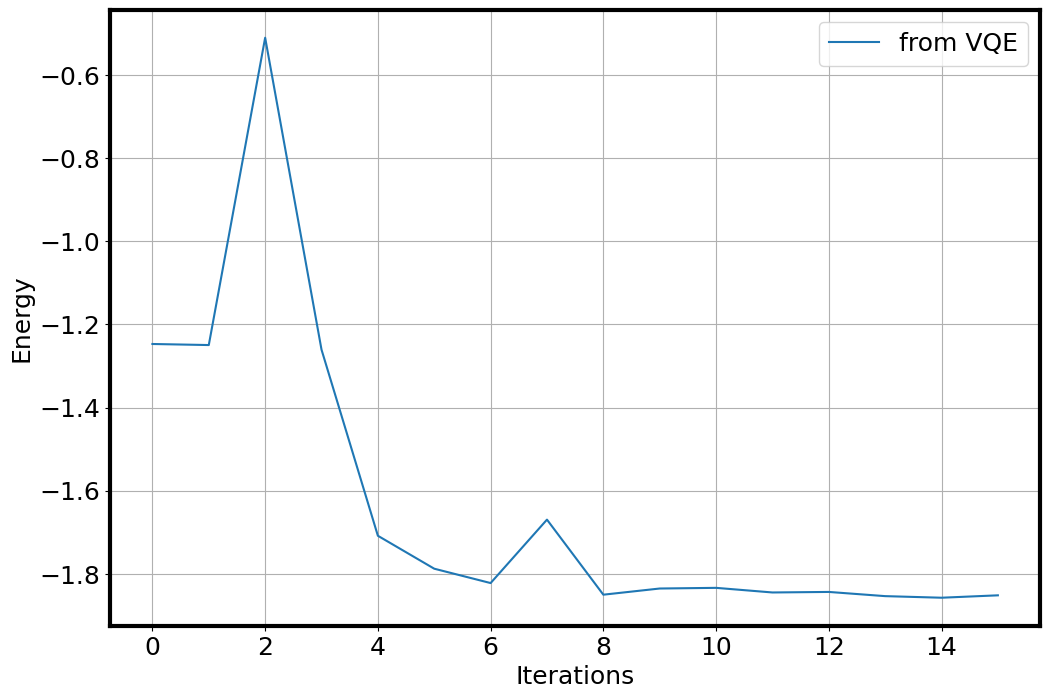

In [ ]:
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
pylab.rcParams["figure.figsize"] = (12, 8)
pylab.rcParams.update({'font.size': 18})
pylab.rcParams['axes.linewidth'] = 3 # set the value globally

plt.plot(np.arange(len(values_aer)), values_aer, label='from VQE with Aer')
plt.legend(loc='upper right')
pylab.grid()
plt.ylabel('Energy')
plt.xlabel('Iterations')

plt.show()

## Running on Garnet

Now, let's run the VQE algorithm on IQM Garnet. We will use the `Qiskit on IQM` transpiler to automate the execution of the algorithm on IQM Garnet. The transpiler will convert the quantum circuit to a format that can be executed on IQM Garnet.

<Figure size 1200x800 with 0 Axes>

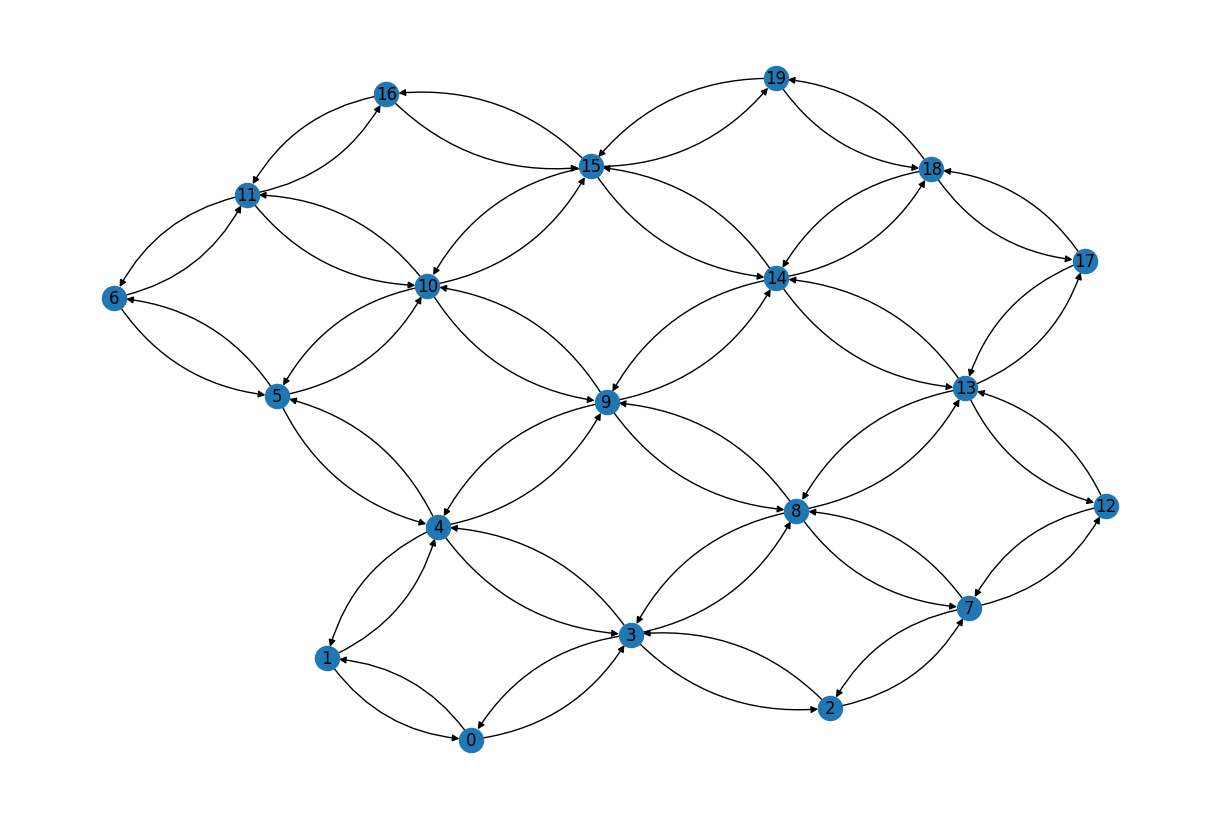

<Figure size 1200x800 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout

plt.figure()
mpl_draw(backend.coupling_map.graph,
         pos=spring_layout(backend.coupling_map.graph, num_iter=200),
         arrows=True, with_labels=True)
plt.figure()

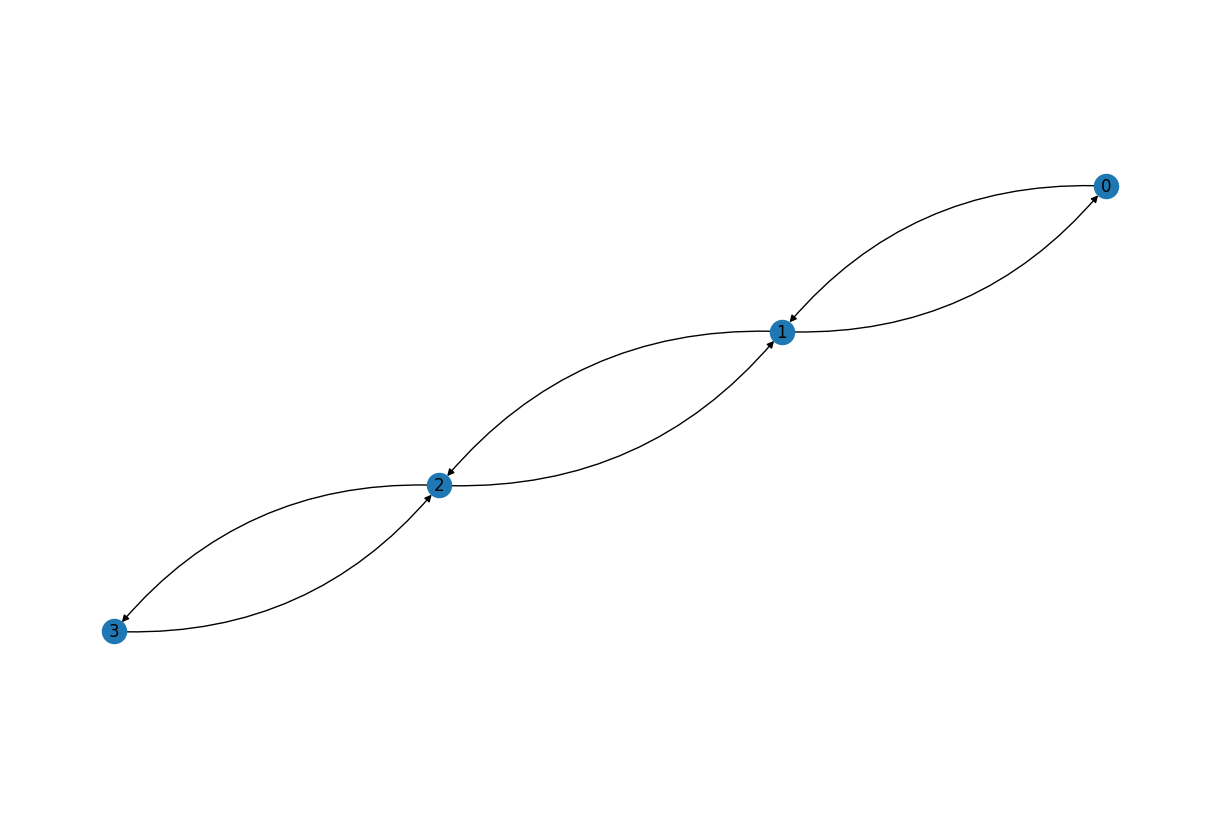

In [23]:
qubit_names  = ["QB3","QB4","QB5",'QB6']
initial_layout = [backend.qubit_name_to_index(name) for name in qubit_names]
mpl_draw(backend.coupling_map.reduce(initial_layout).graph,
         pos=spring_layout(backend.coupling_map.reduce(initial_layout).graph, num_iter=200),
         arrows=True, with_labels=True)

In [ ]:
We will again use the same minimizer to minimize our energy function, but this time we will calculate it 
on the IQM Garnet `backend`.

In [24]:
param_vals = []
values = []

def store_intermediate_result(x):
    global values
    global param_vals 
    mean = ener_func(x)
    param_vals.append(x)
    values.append(mean)


ener_func = ft.partial(calculate_expectation_val, obs = Hspin, circuit = ansatz, bkend = backend, shts=5000,initial_layout=initial_layout)
res = spo.minimize(ener_func, params, method= 'COBYLA', tol=1e-6, options={'maxiter':10},callback=store_intermediate_result) 

In [25]:
print(values)
enervqe_qc = res.fun
params_final_qc = res.x
print(enervqe_qc)

[-0.9782531076795923, -1.0852170701907844, -0.8139071969341669, -1.1185483533983382, -1.3288272890955637, -1.3638804451192477, -1.3688462205683518, -1.2837123547813714, -1.368636187035223, -1.3337682965234847, -1.3737963315185389]
-1.3828353654876013


Finally, let's again plot the energy as a function of the VQE iteration number.

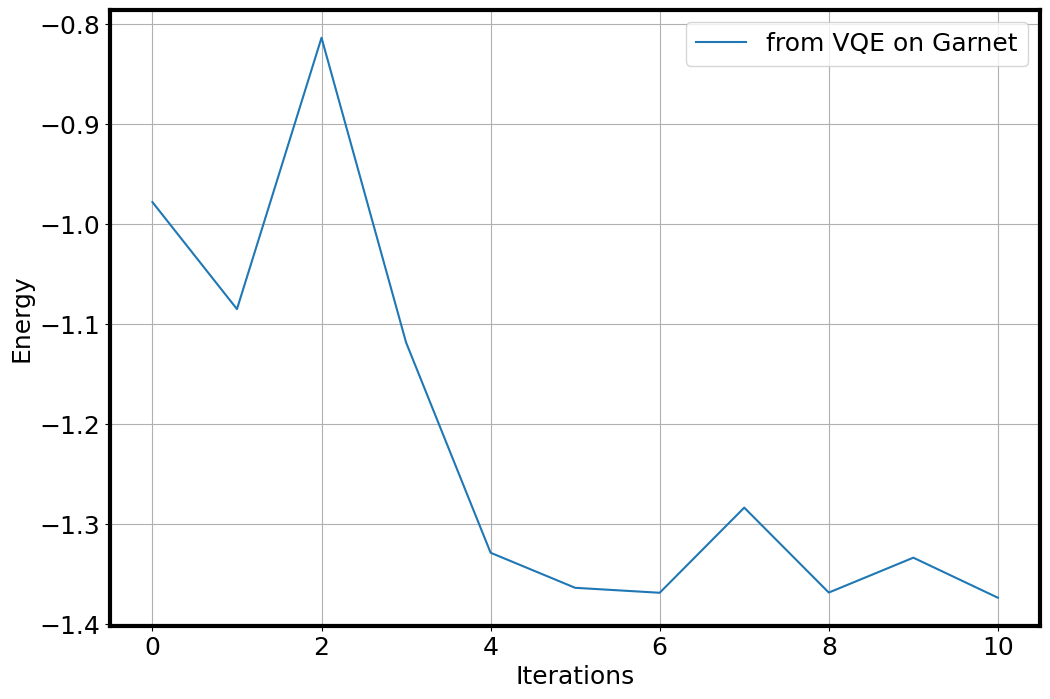

In [26]:
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
pylab.rcParams["figure.figsize"] = (12, 8)
pylab.rcParams.update({'font.size': 18})
pylab.rcParams['axes.linewidth'] = 3 # set the value globally

plt.plot(np.arange(len(values)), values, label='from VQE on Garnet')
plt.legend(loc='upper right')
pylab.grid()
plt.ylabel('Energy')
plt.xlabel('Iterations')

plt.show()

# Running VQE on IQM Garnet
IQM Garnet has 20 qubits and if fewer qubits are required, we can optimize our selection based on the fidelities of the two-qubit gates and the connectivity among the chosen subset of qubits by providing the `initial_layout` parameter to the `transpile` function.

Here we also use the iqm-qiskit function [`optimize_single_qubit_gates`](https://iqm-finland.github.io/qiskit-on-iqm/api/iqm.qiskit_iqm.iqm_transpilation.optimize_single_qubit_gates.html) to optimize the number of single-qubit gates in the transpiled circuit. 

We can iteratively improve the parameters to approximate the solution to the problem. Apart from the batching, the number of measurements can be further reduced by grouping the commuting pauli operators and and only performing calculations for each of the groups.

Further Noise mitigation techniques can be used to improve the results.

So, we were able to run a VQE for the H2 molecule on IQM Garnet 🎉.

## Take it further

Now it's your turn. Tinker with the code above and apply it to your problem. We can't wait to see what you create with IQM Garnet.

In [ ]:

# Copyright 2024 IQM Quantum Computers (PV Sriluckshmy, Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.